In [278]:
#https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
import pandas as pd
from pandas import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import datetime as dt

In [279]:
t0=dt.datetime.now()
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [280]:
train.shape

(1458644, 11)

In [281]:
test.shape

(625134, 9)

In [282]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [283]:
print ("No need to worry about missing value") if train.count().min()==train.shape[0] else print(" Missing values present")

No need to worry about missing value


In [284]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [285]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
train.loc[:,'pickup_date']=train.pickup_datetime.dt.date
train.store_and_fwd_flag=1*(train.store_and_fwd_flag.values=='Y')

test.pickup_datetime=pd.to_datetime(test.pickup_datetime)
test.loc[:,'pickup_date']=test.pickup_datetime.dt.date
test.store_and_fwd_flag=1*(test.store_and_fwd_flag.values=='Y')

In [286]:
train.check_trip_duration=(train.dropoff_datetime-train.pickup_datetime).map(lambda x:x.total_seconds())
duration_diff=train[np.abs(train.trip_duration.values-train.check_trip_duration.values)>1]
print('Trip duration times are good...') if duration_diff.shape[0]==0 else print('OOps')

Trip duration times are good...


In [287]:
train['trip_duration'].max()//3600

979

In [288]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

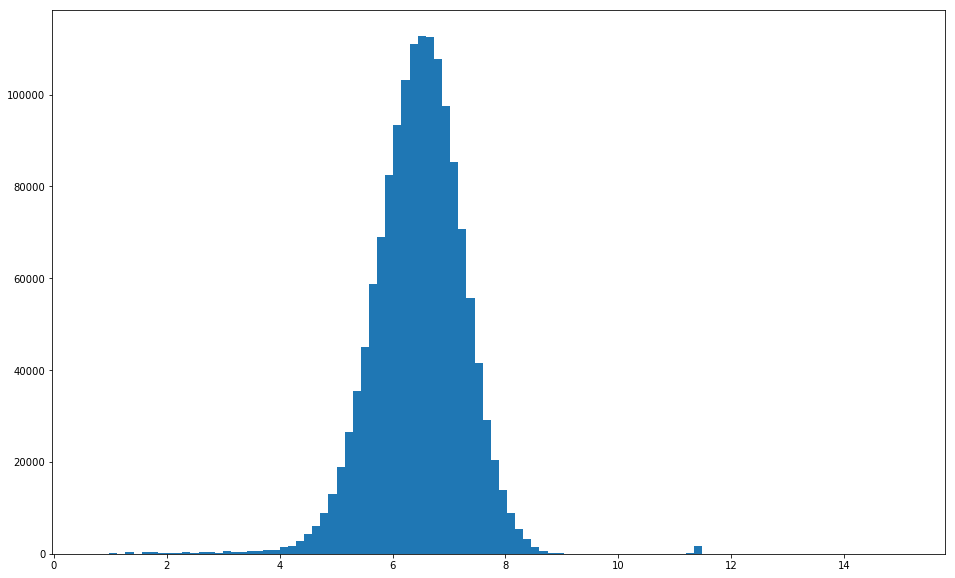

In [289]:
plt.hist(train['log_trip_duration'].values,bins=100)
plt.show()


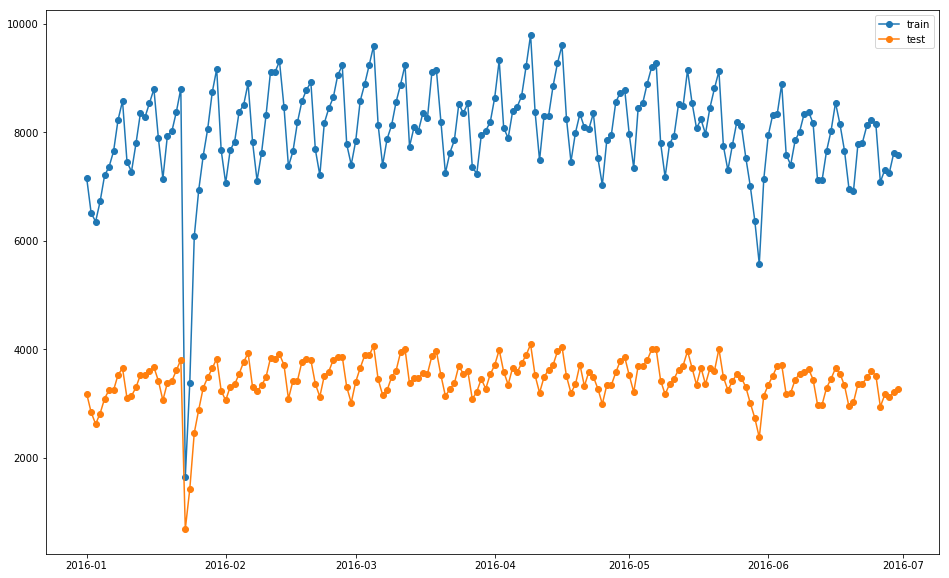

In [290]:
plt.plot(train.groupby('pickup_date').count()['id'],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()['id'],'o-',label='test')
plt.legend(loc=0)
plt.figure(figsize=(5,1))
plt.show()

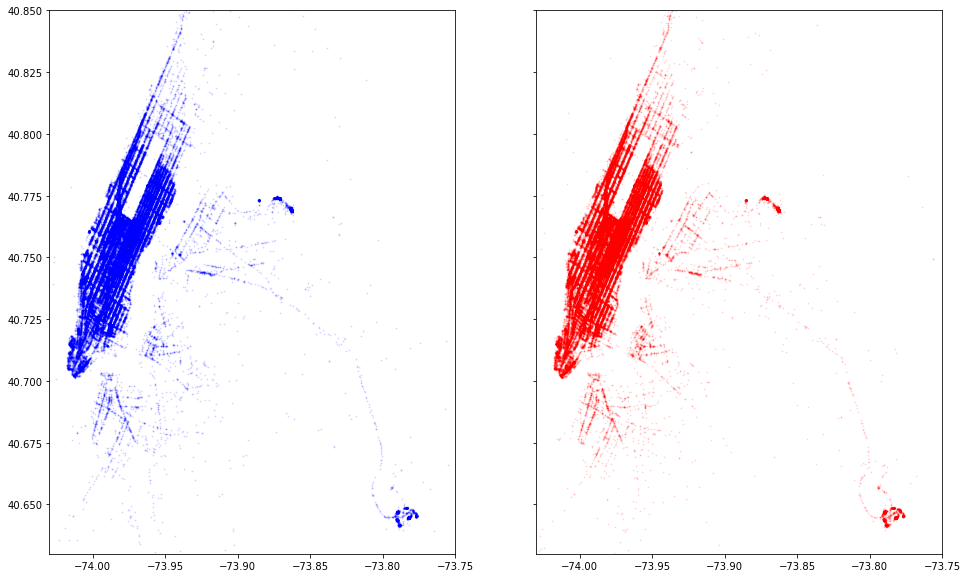

In [291]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig,ax=plt.subplots(ncols=2,sharex=True,sharey=True)
N=100000
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue',label='train')
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],s=1,alpha=.1,color='red',label='test')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [292]:
#Feature extraction
#PCA
coords=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                  train[['dropoff_latitude','dropoff_longitude']].values,
                 test[['pickup_latitude','pickup_longitude']].values,
                 test[['dropoff_latitude','dropoff_longitude']].values))
pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]


test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

(-0.13426186697746503, 0.1017816834266389)

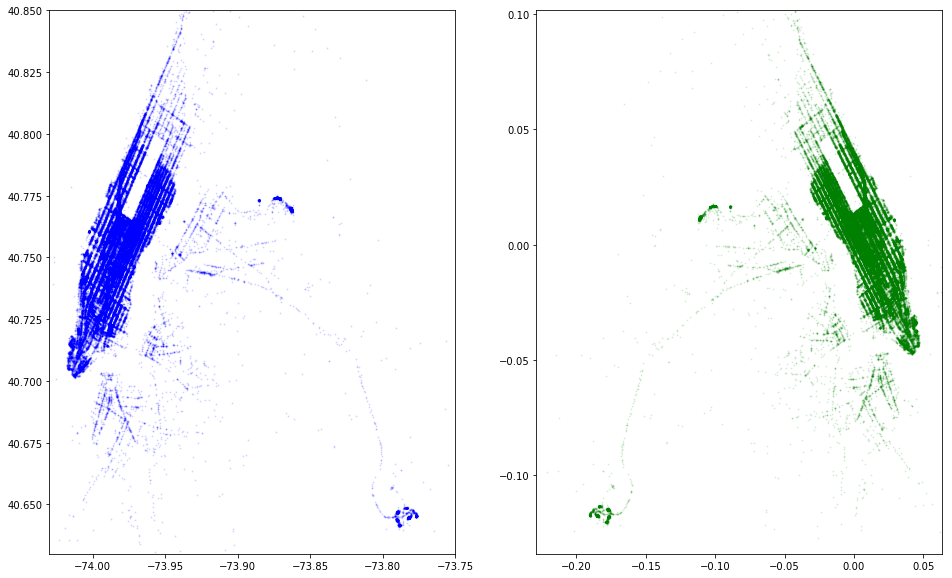

In [293]:
fig,ax=plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue')
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],s=1,alpha=.1,color='green')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders=pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(),pca_borders[:,1].max())

In [294]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [295]:
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                  train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                                 train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                      train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

In [296]:
test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                  test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                                 test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                      test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

In [297]:
train.loc[:,'center_latitude']=(train['pickup_latitude'].values+train['dropoff_latitude'].values)/2
train.loc[:,'center_longitude']=(train['pickup_longitude'].values+train['dropoff_longitude'].values)/2
test.loc[:,'center_latitude']=(test['pickup_latitude'].values+test['dropoff_latitude'].values)/2
test.loc[:,'center_longitude']=(test['pickup_longitude'].values+test['dropoff_longitude'].values)/2

In [298]:
#Datetime Features

In [299]:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekofyear']=train.pickup_datetime.dt.weekofyear
train.loc[:,'pickup_hour']=train.pickup_datetime.dt.hour
train.loc[:,'pickup_minute']=train.pickup_datetime.dt.minute
train.loc[:,'pickup_weekhour']=(train.pickup_datetime.dt.weekday*24)+train.pickup_datetime.dt.hour

In [300]:
test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_weekofyear']=test.pickup_datetime.dt.weekofyear
test.loc[:,'pickup_hour']=test.pickup_datetime.dt.hour
test.loc[:,'pickup_minute']=test.pickup_datetime.dt.minute
test.loc[:,'pickup_weekhour']=(test.pickup_datetime.dt.weekday*24)+test.pickup_datetime.dt.hour

In [301]:
#speed

In [302]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']

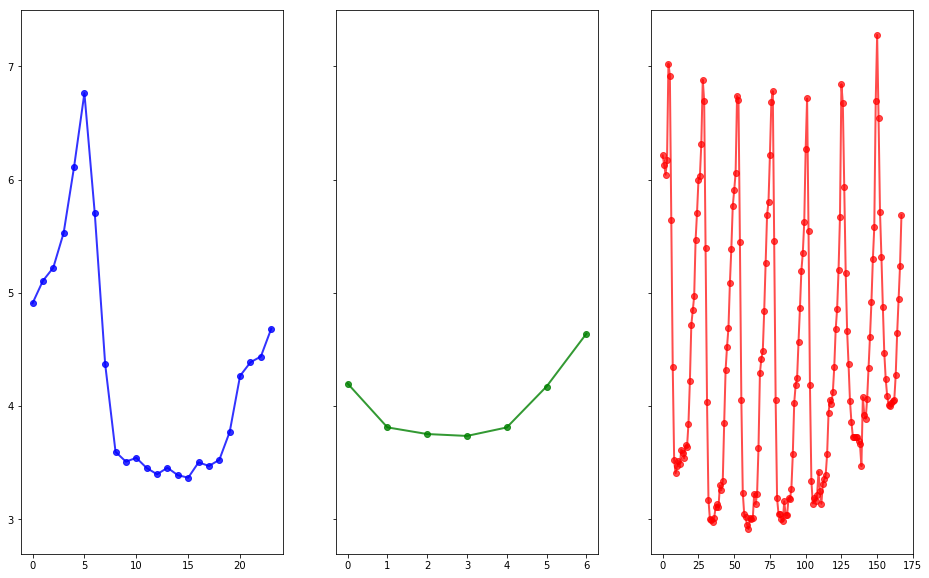

In [303]:
fig,ax=plt.subplots(ncols=3,sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw=2,alpha=.8)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw=2,alpha=.8)
ax[2].plot(train.groupby('pickup_weekhour').mean()['avg_speed_h'],'ro-',lw=2,alpha=.7)

In [304]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'].values,3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'].values,3)

gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
coord_status=pd.merge(coord_speed,coord_count,on=gby_cols)
coord_status=coord_status[coord_status['id']>100]

(40.63, 40.85)

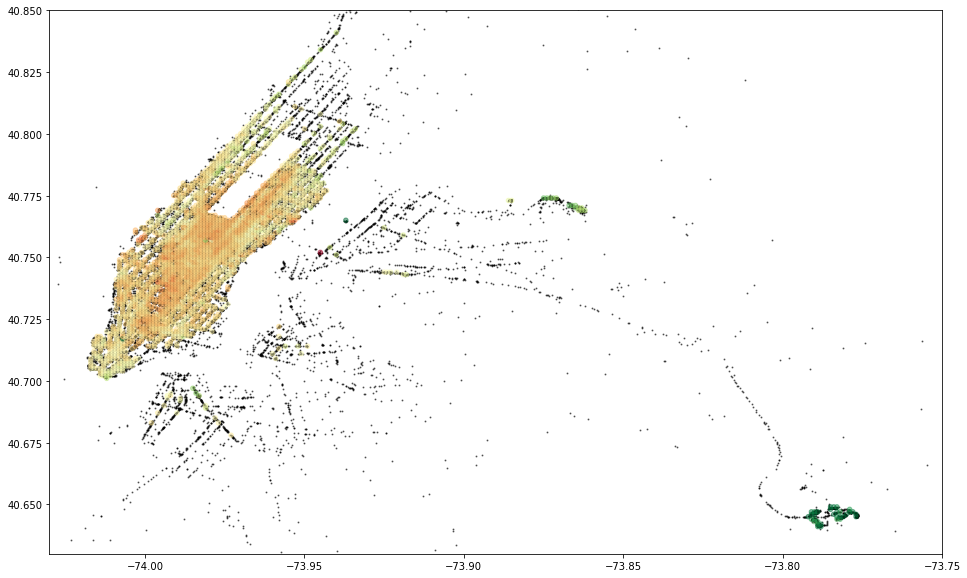

In [305]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train.pickup_longitude.values[:N],train.pickup_latitude.values[:N],color='black',s=1,alpha=.5)
ax.scatter(coord_status.pickup_long_bin.values,coord_status.pickup_lat_bin.values,
           c=coord_status.avg_speed_h.values,cmap='RdYlGn',s=20,alpha=0.5,vmin=1,vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [306]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)

In [307]:
#clustering

In [308]:
sample_ind=np.random.permutation(len(coords))[:500000]
kmeans=MiniBatchKMeans(n_clusters=100,batch_size=10000).fit(coords[sample_ind])

In [309]:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])

(40.63, 40.85)

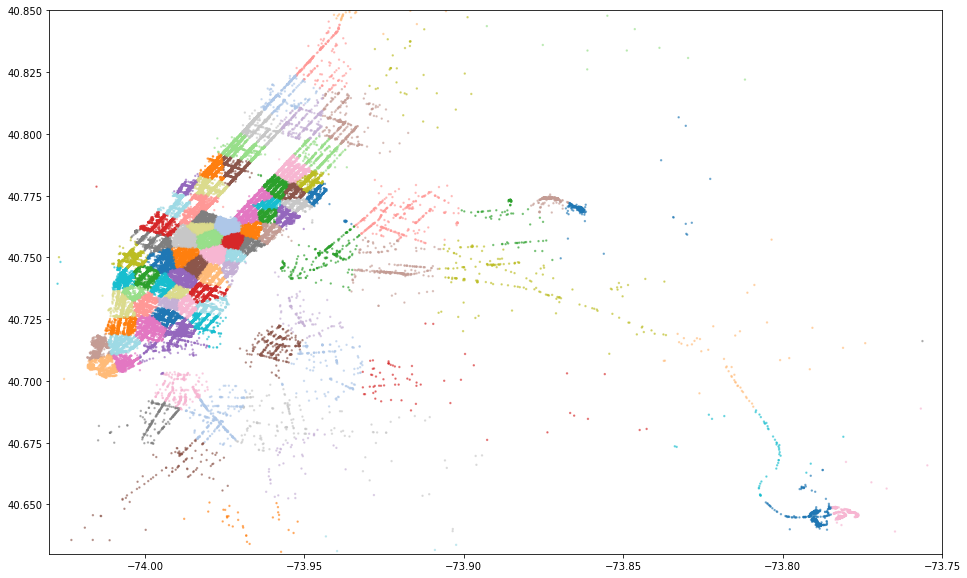

In [310]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=2,alpha=.5,
           c=train['pickup_cluster'].values[:N],cmap='tab20')
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [311]:
#Temporal and geospatial aggregation

In [312]:
for gby_cols in ['pickup_hour','pickup_date','pickup_weekhour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_cols).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns=['%s_gby_%s' % (col,gby_cols) for col in gby.columns]
    train=pd.merge(train,gby,how='left',left_on=gby_cols,right_index=True)
    test=pd.merge(test,gby,how='left',left_on=gby_cols,right_index=True)

In [313]:
for gby_cols in [['center_lat_bin','center_long_bin'],['pickup_hour','center_lat_bin','center_long_bin'],
                ['pickup_hour','pickup_cluster'],['pickup_hour','dropoff_cluster'],
                ['pickup_cluster','dropoff_cluster']]:
    coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats=pd.merge(coord_speed,coord_count,on=gby_cols)
    coord_stats=coord_stats[coord_stats['id']>100]
    coord_stats.columns=gby_cols+['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)

In [314]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

In [315]:
dropoff_counts=df_all.set_index('pickup_datetime')\
.groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster'])\
.agg({'id':'count'})\
.reset_index().set_index('pickup_datetime')\
.groupby('dropoff_cluster').rolling('240min').mean()\
.drop('dropoff_cluster',axis=1)\
.reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index()\
.rename(columns={'pickup_datetime':'pickup_datetime_group','id':'dropoff_cluster_count'})

In [316]:
train['dropoff_cluster_count']=pd.merge(train,dropoff_counts,how='left',on=['pickup_datetime_group', 'dropoff_cluster'])['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count']=pd.merge(test,dropoff_counts,how='left',on=['pickup_datetime_group', 'dropoff_cluster'])['dropoff_cluster_count'].fillna(0)

In [317]:
#OSRM Features

In [318]:
fr1=pd.read_csv('fastest_routes_train_part_1.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])
fr2=pd.read_csv('fastest_routes_train_part_2.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])
test_street_info=read_csv('fastest_routes_test.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])


In [319]:
train_street_info=pd.concat([fr1,fr2])
train=pd.merge(train,train_street_info,how='left',on='id')
test=pd.merge(test,test_street_info,how='left',on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [320]:
feature_names=list(train)
print(np.setdiff1d(train.columns,test.columns))

['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'log_trip_duration'
 'trip_duration']


In [321]:
print(feature_names)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'log_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_weekhour', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_weekhour', 'avg_speed_m_gby_pickup_weekhour', 'log_trip_duration_gby_pickup_weekhour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m

In [322]:
do_not_use_for_training=['id','log_trip_duration','pickup_datetime','dropoff_datetime',
                        'trip_duration','check_trip_duration','pickup_date','avg_speed_h','avg_speed_m',
                        'pickup_lat_bin','pickup_long_bin','center_lat_bin','center_long_bin',
                        'pickup_dt_bin','pickup_datetime_group']
feature_names=[f for f in feature_names if f not in do_not_use_for_training]

In [323]:
print(feature_names)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_weekhour', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_weekhour', 'avg_speed_m_gby_pickup_weekhour', 'log_trip_duration_gby_pickup_weekhour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip_duration_gby_pickup_cluster', 'avg_speed_h_gby_dropoff_cluster', 'avg_speed_m_gby_dropoff_cluster', 'log_trip_duration_gby_dropoff_cluster', 'avg_speed_h_center_lat_bin_c

In [324]:
print('we have %i features' % len(feature_names))

we have 54 features


In [325]:
train[feature_names].count()

vendor_id                                                 1458644
passenger_count                                           1458644
pickup_longitude                                          1458644
pickup_latitude                                           1458644
dropoff_longitude                                         1458644
dropoff_latitude                                          1458644
store_and_fwd_flag                                        1458644
pickup_pca0                                               1458644
pickup_pca1                                               1458644
dropoff_pca0                                              1458644
dropoff_pca1                                              1458644
distance_haversine                                        1458644
distance_dummy_manhattan                                  1458644
direction                                                 1458644
pca_manhattan                                             1458644
center_lat

In [326]:
y=np.log(train['trip_duration'].values+1)
t1=dt.datetime.now()

In [328]:
print('Feature extraction time :%i seconds' %(t1-t0).seconds)

Feature extraction time :156 seconds


In [329]:
#Feature check before modeling

In [334]:
feature_stats=pd.DataFrame({'feature':feature_names})
feature_stats.loc[:,'train_mean']=np.nanmean(train[feature_names].values,axis=0).round(4)
feature_stats.loc[:,'test_mean']=np.nanmean(test[feature_names].values,axis=0).round(4)

feature_stats.loc[:,'train_std']=np.nanstd(train[feature_names].values,axis=0).round(4)
feature_stats.loc[:,'test_std']=np.nanstd(test[feature_names].values,axis=0).round(4)




In [349]:
feature_stats.loc[:,'train_nan']=np.mean(np.isnan(train[feature_names].values),axis=0).round(3)
feature_stats.loc[:,'test_nan']=np.mean(np.isnan(test[feature_names].values),axis=0).round(3)

feature_stats.loc[:,'train_test_mean_diff']=np.abs(feature_stats['train_mean']-feature_stats['test_mean'])/\
np.abs(feature_stats['train_std']+feature_stats['test_std'])*2

feature_stats.loc[:,'train_test_nan_diff']=np.abs(feature_stats['train_nan']-feature_stats['test_nan'])

feature_stats=feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature','train_test_mean_diff']].tail()

,feature,train_test_mean_diff
47,avg_speed_h_pickup_cluster_dropoff_cluster,0.002398
39,avg_speed_h_center_lat_bin_center_long_bin,0.002543
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_weekofyear,0.002872


In [345]:
feature_stats

,feature,train_mean,test_mean,train_std,test_std,train_nan,test_nan,train_test_mean_diff
0,vendor_id,1.5350,1.5349,0.4988,0.4988,0.000,0.000,0.000200
1,passenger_count,1.6645,1.6618,1.3142,1.3113,0.000,0.000,0.002057
2,pickup_longitude,-73.9735,-73.9736,0.0709,0.0734,0.000,0.000,0.001386
3,pickup_latitude,40.7509,40.7509,0.0329,0.0298,0.000,0.000,0.000000
4,dropoff_longitude,-73.9734,-73.9735,0.0706,0.0726,0.000,0.000,0.001397
5,dropoff_latitude,40.7518,40.7518,0.0359,0.0358,0.000,0.000,0.000000
6,store_and_fwd_flag,0.0055,0.0055,0.0741,0.0739,0.000,0.000,0.000000
7,pickup_pca0,0.0000,0.0002,0.0708,0.0734,0.000,0.000,0.002774
8,pickup_pca1,-0.0004,-0.0004,0.0330,0.0298,0.000,0.000,0.000000
9,dropoff_pca0,-0.0001,-0.0000,0.0708,0.0729,0.000,0.000,0.001392
